In [1]:
from matplotlib import pyplot as plt
import numpy as np
import json
import os
from argoverse.map_representation.map_api import ArgoverseMap

am = ArgoverseMap()



In [2]:
root_dir = "best_smoothing_nonsmoothing/"
file_list = os.listdir(root_dir)


index = 0
json_dict = {}
with open(root_dir + file_list[index]) as json_data:
    json_dict = json.load(json_data)

preds = np.array(json_dict['preds'])
waypoint_preds = np.array(json_dict['waypoint_preds'])
agent_labels = np.array(json_dict['agent_labels'])


In [14]:
import math
from shapely.geometry import LineString

def draw(AGENT, AV, json_dict):
    def denormalization(arr, angle, translation_x, translation_y):
#         arr[...,0] -= np.mean(arr[...,0])
#         arr[...,1] -= np.mean(arr[...,1])
#         json_dict['preds'] = [[np.array(json_dict['preds'])[0][i] - min(json_dict['preds'][0][i][:2]) for i in range(len(json_dict['preds'][0]))]]    # calculate x's mean and y's mean in predict

        theta = (angle)/180*math.pi
        c, s = np.cos(theta), np.sin(theta)
        R = np.array(((c, -s), (s, c)))

        #rotate
        arr = np.array([R.dot(arr[...,:2][i].reshape((2,1))).flatten() for i in range(len(arr[...,:2]))])

        #translate
        arr[...,0] += translation_x
        arr[...,1] += translation_y
        arr[...,0] += (AGENT[19,0] - AGENT[0,0])
        arr[...,1] += (AGENT[19,1] - AGENT[0,1])
        return arr
    
    plt.figure(figsize=(8, 8))
    x_mean = np.array(json_dict['preds'])[0,:,0,0].mean()
    y_mean = np.array(json_dict['preds'])[0,:,0,1].mean()

    # Recalculate angle
    angle_ans = -json_dict['rotation']
    print("=" * 100)

    xmin, xmax, ymin,ymax = [9999], [-9999], [9999], [-9999]

    json_dict['preds'] = [[np.array(json_dict['preds'])[0][i] - min(json_dict['preds'][0][i][:2]) for i in range(len(json_dict['preds'][0]))]]    # calculate x's mean and y's mean in predict

    for p in json_dict['preds'][0]:
        p = denormalization(np.array(p), angle_ans, -json_dict['translation'][0], -json_dict['translation'][1])
        plt.plot(p[...,0], p[...,1])
        plt.scatter(p[...,0][0], p[...,1][0])
        plt.scatter(p[...,0][-1], p[...,1][-1], linewidth=2)
        xmin, xmax = min(np.append(xmin, p[...,0])), max(np.append(xmax, p[...,0]))
        ymin, ymax = min(np.append(ymin, p[...,1])), max(np.append(ymax, p[...,1]))
        

    plt.plot(AGENT[...,0],AGENT[...,1], color='blue')
    plt.scatter(AGENT[...,0][-1],AGENT[...,1][-1], color='blue',linewidth=8)
    plt.scatter(AGENT[...,0][19],AGENT[...,1][19], color='blue')
    plt.plot(AV[...,0],AV[...,1], color='black')
    plt.scatter(AV[...,0][-1],AV[...,1][-1], color='black')

    xmin = min(np.append(np.append(AGENT[...,0], AV[...,0]),xmin))
    xmax = max(np.append(np.append(AGENT[...,0], AV[...,0]),xmax))
    ymin = min(np.append(np.append(AGENT[...,1], AV[...,1]),ymin))
    ymax = max(np.append(np.append(AGENT[...,1], AV[...,1]),ymax))
    
    local_lane_polygons = am.find_local_lane_polygons([xmin, xmax, ymin, ymax], city_name)
    print(xmin, xmax, ymin, ymax)
    for l in local_lane_polygons:
        plt.plot(l[...,0],l[...,1], linewidth='0.5', color='gray')
    plt.show()


    # for p in json_dict['preds'][0]:
    #     x = np.array(p)[...,0]
    #     y = np.array(p)[...,1]
    #     plt.plot(x,y)
    # plt.show()

29.087351591804204 80.39568290689087 2321.653899413497 2331.238909985225


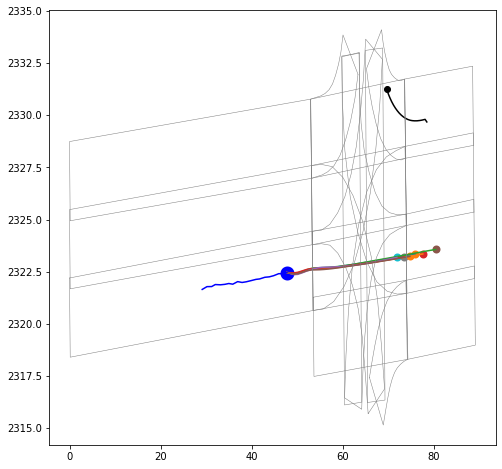

-48.35895303654649 38.5474495154195 2321.683434764134 2328.2434404620817


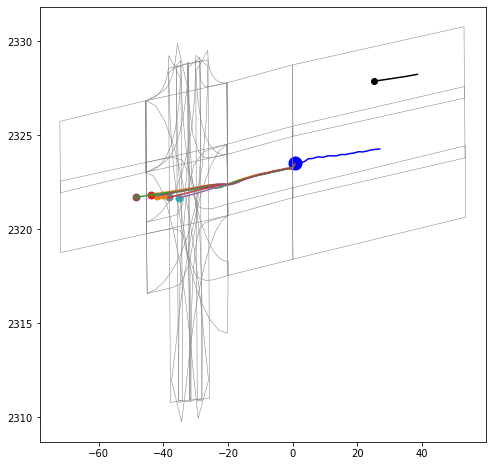

1604.0806742844245 1674.4992852025518 229.28186118392603 314.57902248445043


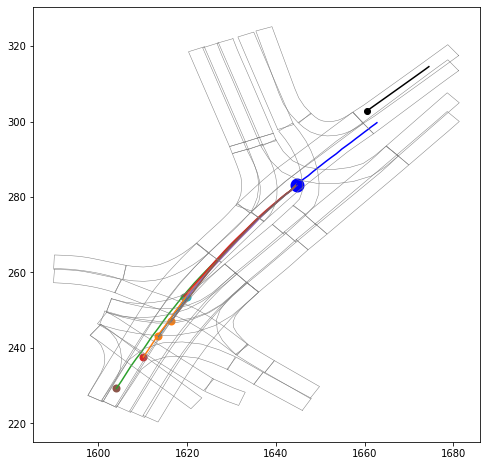

1356.3204654684484 1494.1560172302604 512.8724731714718 575.3155013136909


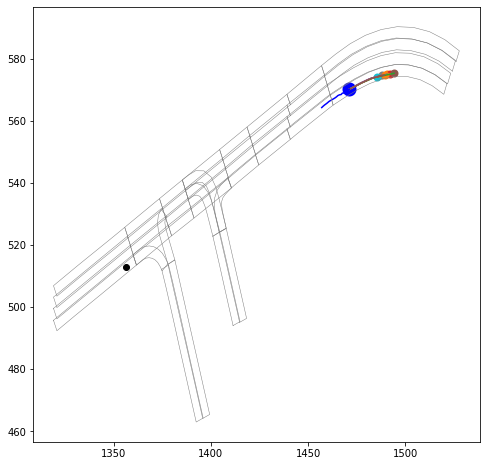

111.610008414134 148.82100052539707 3954.042725447564 3974.2859870254474


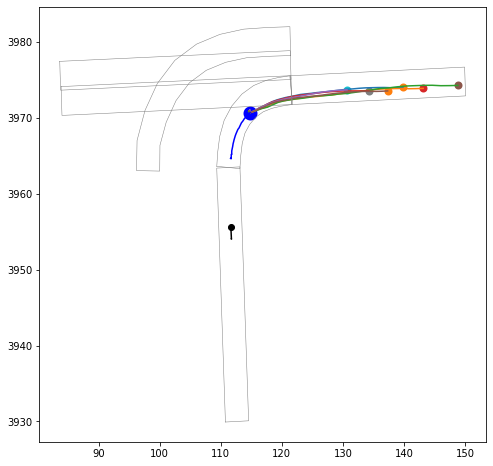

1459.022539096516 1482.4737140375862 263.2695644547222 325.80791591984337


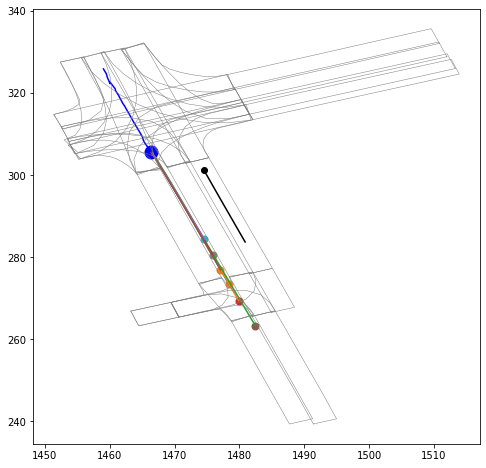

1258.9343251320372 1281.1225236260348 123.52248247226345 152.78574901344857


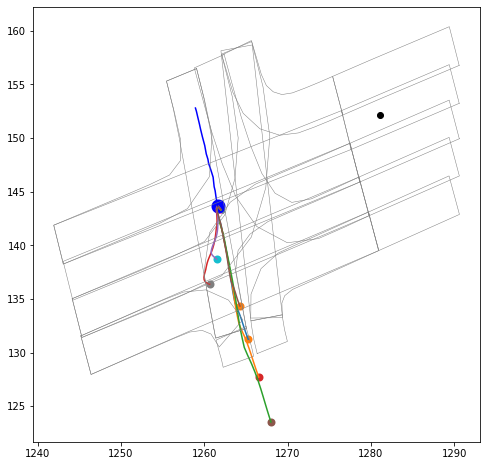

-122.06060506515318 -30.583080991588382 2316.246918942973 2322.651666913675


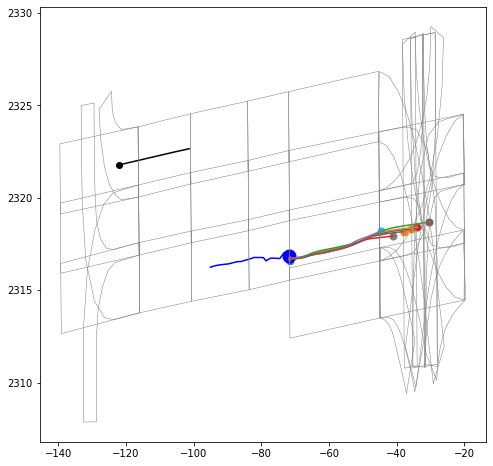

1613.838195973873 1664.3954034403243 231.208132429121 289.21604241418885


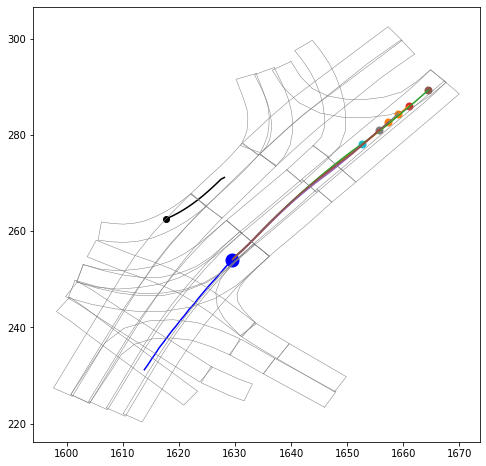

104.94658498416361 113.60657295920264 3865.755499761989 3923.5391782101947


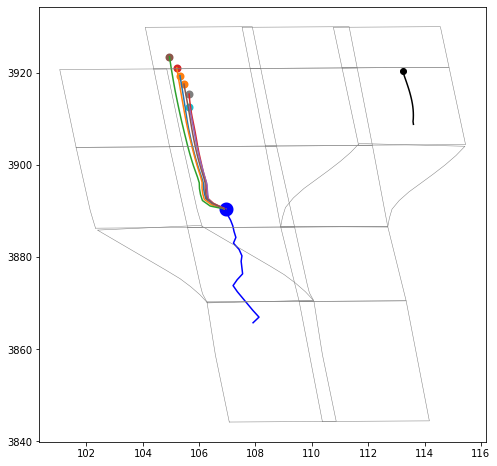

In [15]:
import csv

for i in range(10,20):

    file_list = sorted(os.listdir(root_dir), key=lambda a : str(a.split('.')[0]))
    index = i

    json_dict = {}

    with open(root_dir + file_list[index], 'r') as json_data:
        json_dict = json.load(json_data)


    AV = []
    AGENT = []
    city_name = ""

    with open("data/argoverse_raw/test/" + json_dict['csv_file']) as csvfile: #val: 33, Test:25
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            if row[2] == 'AGENT':
                AGENT.append([float(row[3]), float(row[4])])

            elif row[2] == "AV":
                AV.append([float(row[3]), float(row[4])])

            city_name = row[-1]
    AV = np.array(AV)
    AGENT = np.array(AGENT)

    draw(AGENT, AV, json_dict)